In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input, decode_predictions
#from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import keras.utils as image
from keras.layers import Input,Dense,Dropout,Embedding,LSTM
from keras.layers import Concatenate,add
import pickle
from keras import Input
from keras.models import load_model

In [5]:
#Read Text Captions
def readTextFile(path):
    with open(path) as f:
        captions=f.read()
    return captions

In [6]:
captions =readTextFile("./captions.txt")
captions=captions.split('\n')[:-1]
print(captions[1])

1000268201_693b08cb0e.jpg,A girl going into a wooden building .


In [7]:
print(len(captions))

40455


In [8]:
first,second=captions[1].split(',')
print(first.split(".")[0])
print(second)

1000268201_693b08cb0e
A girl going into a wooden building .


In [9]:
#Dictionary to Map each image with the list of captions it have
descriptions={}

for x in captions:
    
    first,second = x.split(',')
    img_name=first.split(".")[0]
    
    #if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name]=[]
    descriptions[img_name].append(second)


In [10]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

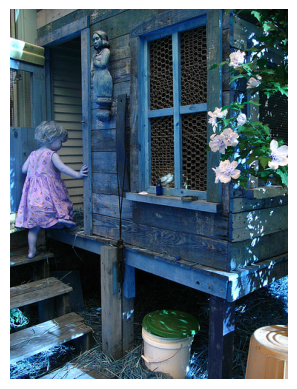

In [11]:
IMG_PATH="Images/"
import cv2
import matplotlib.pyplot as plt


img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Because it reads image in black  and white format
plt.imshow(img)
plt.axis("off")
plt.show()


# Data Cleaning

In [12]:
import re
def clean_text(sentence):
    sentence=sentence.lower()
    sentence=re.sub("[^a-z]+"," ",sentence)
    sentence=sentence.split()
    sentence=[s for s in sentence if len(s)>1]
    sentence=" ".join(sentence)
    return sentence

In [13]:
clean_text("A cat is sitting over the house # 64")

'cat is sitting over the house'

In [14]:
#clean all captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i]=clean_text(caption_list[i])
        

In [15]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [16]:
descriptions["2857558098_98e9249284"]

['dog is chewing on big branch',
 'dog shews on big stick',
 'dog with branch in its mouth',
 'little dog chews on big stick',
 'small dog chews on big stick']

In [17]:
#write the data to text file
with open("descriptions_1.txt","w") as f:
 f.write(str(descriptions))
f.close()


# Vocabulary

In [18]:
import json
descriptions=None
with open("descriptions_1.txt",'r') as f:
    descriptions=f.read()
json_acceptable_string=descriptions.replace("'","\"")
descriptions=json.loads(json_acceptable_string)

In [19]:
print(type(descriptions))

<class 'dict'>


In [20]:
#Vocab
vocab =set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
print("Vocab Size :%d"% len(vocab))


Vocab Size :8424


In [21]:
#Total number of words acress all the sentences
total_words=[]
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]

print("Total Words %d"%len(total_words))

Total Words 373803


In [22]:
print(total_words[:10])

['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs']


In [23]:
import collections
counter=collections.Counter(total_words)
freq_cnt=dict(counter)
print(len(freq_cnt.keys()))

8424


In [24]:
freq_cnt

{'child': 1545,
 'in': 18986,
 'pink': 739,
 'dress': 348,
 'is': 9345,
 'climbing': 507,
 'up': 1302,
 'set': 109,
 'of': 6723,
 'stairs': 109,
 'an': 2432,
 'entry': 1,
 'way': 53,
 'girl': 3328,
 'going': 149,
 'into': 1074,
 'wooden': 284,
 'building': 510,
 'little': 1768,
 'playhouse': 6,
 'the': 18419,
 'to': 3176,
 'her': 1178,
 'cabin': 4,
 'black': 3848,
 'dog': 8138,
 'and': 8862,
 'spotted': 38,
 'are': 3504,
 'fighting': 133,
 'tri': 14,
 'colored': 221,
 'playing': 2008,
 'with': 7765,
 'each': 430,
 'other': 773,
 'on': 10745,
 'road': 398,
 'white': 3959,
 'brown': 2578,
 'spots': 29,
 'staring': 57,
 'at': 2915,
 'street': 944,
 'two': 5642,
 'dogs': 2125,
 'different': 46,
 'breeds': 5,
 'looking': 743,
 'pavement': 48,
 'moving': 41,
 'toward': 146,
 'covered': 372,
 'paint': 62,
 'sits': 577,
 'front': 1386,
 'painted': 64,
 'rainbow': 22,
 'hands': 246,
 'bowl': 30,
 'sitting': 1368,
 'large': 1236,
 'small': 1278,
 'grass': 1622,
 'plays': 526,
 'fingerpaints': 3,

In [25]:
#sort this dictionary according to the frq count
sorted_freq_cnt=sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

threshold=10
sorted_freq_cnt=[x for x in sorted_freq_cnt if x[1]>threshold]
total_words=[x[0] for x in sorted_freq_cnt]

In [26]:
print(len(total_words))

1845


# Training and Testing Datasets

In [27]:
train_file_data=readTextFile("train.txt")
test_file_data=readTextFile("test.txt")

In [28]:
print(train_file_data)

2814406547_a237ef0122.jpg
2814406547_a237ef0122.jpg
2814406547_a237ef0122.jpg
2815256108_fc1302117d.jpg
2815256108_fc1302117d.jpg
2815256108_fc1302117d.jpg
2815256108_fc1302117d.jpg
2815256108_fc1302117d.jpg
2815745115_c8479d560c.jpg
2815745115_c8479d560c.jpg
2815745115_c8479d560c.jpg
2815745115_c8479d560c.jpg
2815745115_c8479d560c.jpg
2815755985_0fa55544c0.jpg
2815755985_0fa55544c0.jpg
2815755985_0fa55544c0.jpg
2815755985_0fa55544c0.jpg
2815755985_0fa55544c0.jpg
2815788792_d226215d10.jpg
2815788792_d226215d10.jpg
2815788792_d226215d10.jpg
2815788792_d226215d10.jpg
2815788792_d226215d10.jpg
2816259113_461f8dedb0.jpg
2816259113_461f8dedb0.jpg
2816259113_461f8dedb0.jpg
2816259113_461f8dedb0.jpg
2816259113_461f8dedb0.jpg
2817230861_d27341dec0.jpg
2817230861_d27341dec0.jpg
2817230861_d27341dec0.jpg
2817230861_d27341dec0.jpg
2817230861_d27341dec0.jpg
281754914_bc8119a0ed.jpg 
281754914_bc8119a0ed.jpg 
281754914_bc8119a0ed.jpg 
281754914_bc8119a0ed.jpg 
281754914_bc8119a0ed.jpg 
2817847072_5

In [29]:
train=[row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test=[row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
print(train)

['2814406547_a237ef0122', '2814406547_a237ef0122', '2814406547_a237ef0122', '2815256108_fc1302117d', '2815256108_fc1302117d', '2815256108_fc1302117d', '2815256108_fc1302117d', '2815256108_fc1302117d', '2815745115_c8479d560c', '2815745115_c8479d560c', '2815745115_c8479d560c', '2815745115_c8479d560c', '2815745115_c8479d560c', '2815755985_0fa55544c0', '2815755985_0fa55544c0', '2815755985_0fa55544c0', '2815755985_0fa55544c0', '2815755985_0fa55544c0', '2815788792_d226215d10', '2815788792_d226215d10', '2815788792_d226215d10', '2815788792_d226215d10', '2815788792_d226215d10', '2816259113_461f8dedb0', '2816259113_461f8dedb0', '2816259113_461f8dedb0', '2816259113_461f8dedb0', '2816259113_461f8dedb0', '2817230861_d27341dec0', '2817230861_d27341dec0', '2817230861_d27341dec0', '2817230861_d27341dec0', '2817230861_d27341dec0', '281754914_bc8119a0ed', '281754914_bc8119a0ed', '281754914_bc8119a0ed', '281754914_bc8119a0ed', '281754914_bc8119a0ed', '2817847072_5eb3bc30ac', '2817847072_5eb3bc30ac', '281

In [49]:
train[:5]

['2814406547_a237ef0122',
 '2814406547_a237ef0122',
 '2814406547_a237ef0122',
 '2815256108_fc1302117d',
 '2815256108_fc1302117d']

In [50]:
#prepare description for the training data
# tweak- add<S> and <E> token to our training data
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [51]:
train_descriptions["2814406547_a237ef0122"]

['startseq man in colorful outfit stands over trashcan outdoors endseq',
 'startseq man in robe leaning against trashcan and watching pedestrians endseq',
 'startseq man wears floral bathroom as he stands over trashcan endseq',
 'startseq person wearing clothes with floral pattern leans on trashcan cage endseq',
 'startseq person wearing flowered robe holding cup of coffee leaning on trashcan endseq']

# transfer learning for feature extraction of images
#-Image->feature
#-Text--->Feature
We will be sing pretrained model for feature extraction that is ResNet 50

In [ ]:
#ResNet model is a very deep model 
#We will extract features that is relevant to us

In [53]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [54]:
model_new = Model(model.input,model.layers[-2].output)

In [55]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
  # Normalization
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


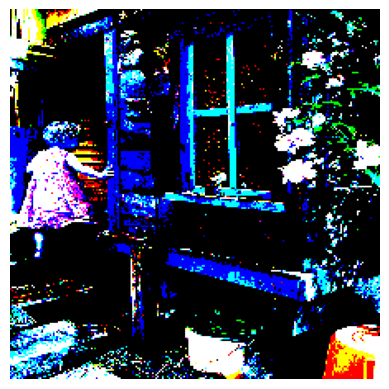

In [56]:
img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [57]:
def encode_image(img):
  img = preprocess_img(img)
  feature_vector = model_new.predict(img)
  feature_vector = feature_vector.reshape(feature_vector.shape[1],)
  #print(feature_vector.shape)
  return feature_vector

In [140]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

1/1 [==============================] - 0s 323ms/step


array([0.06536549, 0.16782692, 0.3251846 , ..., 0.0511154 , 0.32817933,
       1.0043334 ], dtype=float32)

In [158]:
encoding_train={}
img_path=IMG_PATH+"/"+img_id+".jpg"
encoding_train[IMG_PATH+"3356642567_f1d92cb81b"]=encode_image(img_path)

1/1 [==============================] - 0s 285ms/step


In [2]:
# Store everything to thr disk
# with open("encoded_train_feature.pkl","wb")as f:
#     pickle.dump(encoding_train,f)
    

In [1]:
# start=time()
# encoding_train={}
# for ix,img_id in enumerate(train):
#     img_path=IMG_PATH+"/"+img_id+".jpg"
#     encoding_train[img_id]=encode_image(img_path)
    
#     if ix%100==0:
#         print("Test Encoding in Progress Time step %d "%ix)
# end_t=time()
# print("Total Time Taken for test:",end_t-start)

In [62]:
#Store everything to thr disk
#with open("encoded_train_feature.pkl","wb")as f:
 #   pickle.dump(encoding_train,f)
    

In [148]:
encoding_test={}
img_path=IMG_PATH+"/"+img_id+".jpg"
encoding_test[IMG_PATH+"3356642567_f1d92cb81b"]=encode_image(img_path)

1/1 [==============================] - 0s 237ms/step


In [150]:
with open("encoded_test_features.pkl","wb") as f:
     pickle.dump(encoding_test,f)

In [143]:
start=time()
encoding_test={}
for ix,img_id in enumerate(test):
    img_path=IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id]=encode_image(img_path)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
end_t=time()
print("Total Time Taken for test:",end_t-start)

1/1 [==============================] - 0s 290ms/step
Test Encoding in Progress Time step 0 
1/1 [==============================] - 0s 279ms/step
Test Encoding in Progress Time step 100 
1/1 [==============================] - 0s 250ms/step
Test Encoding in Progress Time step 200 
1/1 [==============================] - 0s 237ms/step
Test Encoding in Progress Time step 300 
1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 263ms/step
Test Encoding in Progress Time step 400 
1/1 [==============================] - 0s 247ms/step
Test Encoding in Progress Time step 500 
1/1 [==============================] - 0s 218ms/step
Test Encoding in Progress Time step 600 
1/1 [==============================] - 0s 290ms/step


KeyboardInterrupt: 

In [23]:
#st  ore everything to thr disk
#with open("encoded_train_feature.pkl","wb")as f:
   # pickle.dump(encoding_test,f)
    

In [64]:
#with open("encoded_test_features.pkl","wb") as f:
 #   pickle.dump(encoding_test,f)

# Data Pre processing for captions

In [59]:
len(total_words)

1845

In [60]:
word_to_idx={}
idx_to_word={}

for i,word in enumerate(total_words):
    word_to_idx[word]=i+1
    idx_to_word[i]=word

In [169]:
with open("./storage/word_to_idx.pkl","wb") as w2i:
    pickle.dump(word_to_idx,w2i)
with open("./storage/idx_to_word.pkl","wb") as i2w:
    pickle.dump(idx_to_word,i2w)

In [61]:
word_to_idx["dog"]
idx_to_word[1]

'the'

In [62]:
#Two special words
print(len(idx_to_word))

1845


In [63]:
idx_to_word[1846]='startseq'
word_to_idx['startseq']=1846
idx_to_word[1847]='endseq'
word_to_idx['endseq']=1847
vocab_size=len(word_to_idx)+1
print("Vocab Size",vocab_size)


Vocab Size 1848


In [64]:
max_len=0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len=max(max_len,len(cap.split()))
print(max_len)

30


# Data Load


In [164]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
x1,x2,y=[],[],[]
n=0
 while True:
    for key,desc_list in train_descriptions.itme():
        n+=1
        photo=encoding_train[key+".jpg"]
        for desc in desc_list:
            seq=[word_to_idx[word] for word in desc.split() if word in word_to_idx]
            for i in range(1,len(seq)):
                xi=seq[0:i]
                yi=seq[i]
                
                xi=pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
    
                yi=to_categorcial([yi],num_classes=vocab_size)[0]
                x1.append(photo)
                x2.append(xi)
                y.append(yi)
            if n==batch_size:
                yield[[np.array(x1),np.array(x2)],np.array(y)]
                x1,x2,y=[],[],[]
                n=0

In [166]:
#Word Embeddigs
f=open("glove.6B.50d.txt",encoding='utf8')


In [167]:
embedding_index={}
for line in f:
    values=line.split()
    print(values)
    word=values[0]
    word_embedding=np.array(values[1:],dtype='float')
    embedding_index[word]=word_embedding
    

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [104]:
f.close()

In [105]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [70]:
def get_embedding_matrix():
    emb_dim=50
    matrix=np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector=embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx]=embedding_vector
            
    return matrix

In [71]:
word_to_idx['the']

2

In [72]:
embedding_matrix=get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [73]:
embedding_matrix[1847]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [106]:
input_img_features=Input(shape=(2048,))
inp_img1=Dropout(0.3)(input_img_features)
inp_img2=Dense(256,activation='relu')(inp_img1)

In [107]:
input_captions=Input(shape=(max_len,))
inp_cap1=Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2=Dropout(0.3)(inp_cap1)
inp_cap3=LSTM(256)(inp_cap2)

In [108]:
decoder1=add([inp_img2,inp_cap3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

model=Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [109]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 30, 50)       92400       ['input_5[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_4[0][0]']                
                                                                                            

In [110]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False

In [111]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

# Training Model

In [112]:
epochs=20
batch_size=3
steps=len(train_descriptions) 


In [113]:
def train():
    for i in range(epochs):
        generator=data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_genrator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [174]:
model=load_model('best_model.h5')

# Predications

In [155]:
def predict_captions(photo):
in_text="startseq"
for i in range(max_len):
    sequence=[word_to_idx[w] for w in in_text.split() if w in word_to_idx]
    sequence=pad_sequences([sequence],max_len,padding='post')
        
    ypred=model.predict([photo,sequence])
    ypred=ypred.argmax()  #word with max prob always-Greedy Sample
    word=idx_to_word[ypred]
    in_text +=(' '+word)
        
    if word=='endseq':
        break
            
    final_caption=in_text.split()[1:-1]
    final_caption=' '.join(final_caption)
        
    return final_caption
        
        

1/1 [==============================] - 3s 3s/step



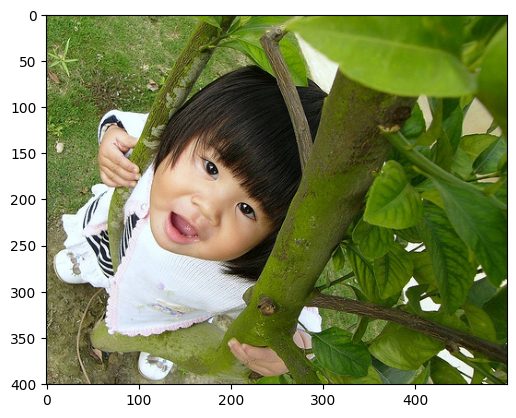

1/1 [==============================] - 0s 51ms/step



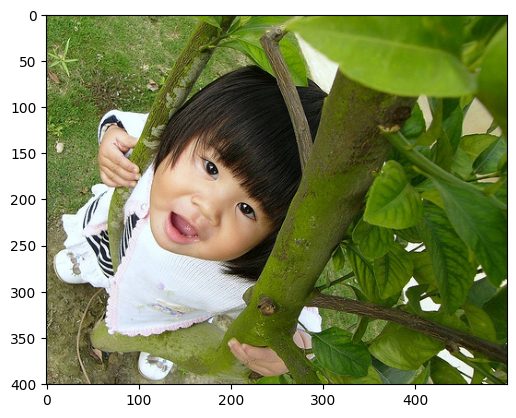

1/1 [==============================] - 0s 53ms/step



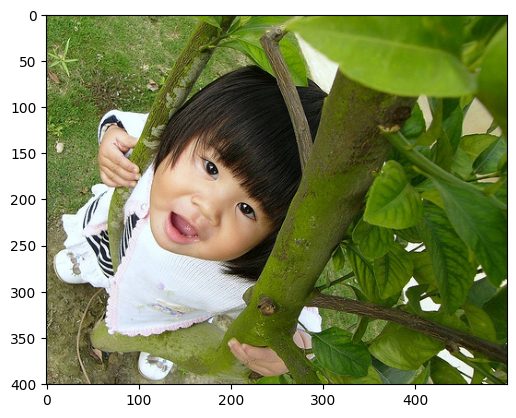

1/1 [==============================] - 0s 57ms/step



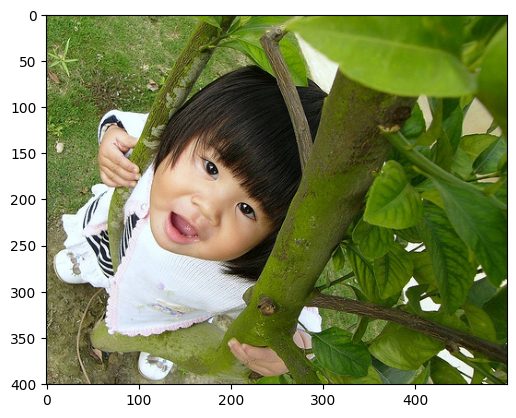

1/1 [==============================] - 0s 51ms/step



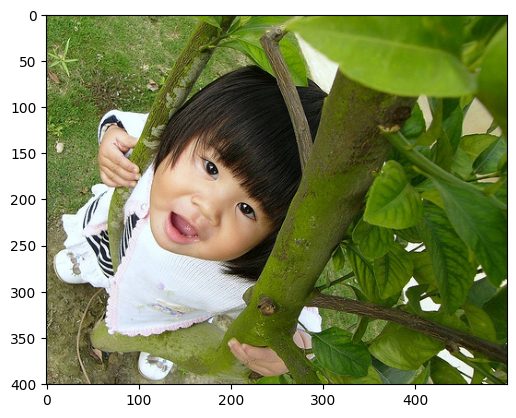

1/1 [==============================] - 0s 51ms/step



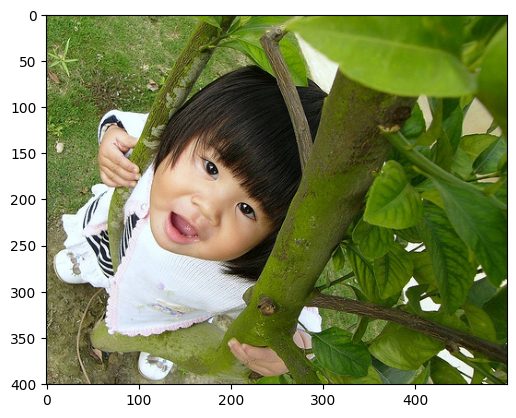

1/1 [==============================] - 0s 50ms/step



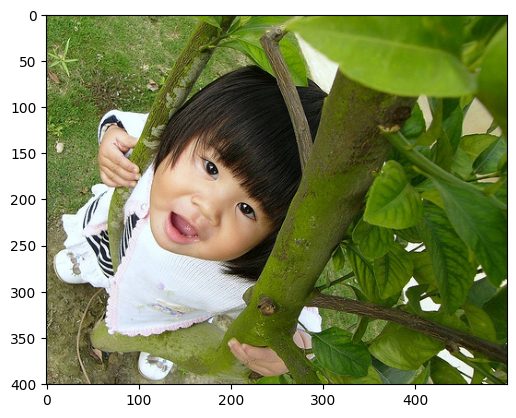

1/1 [==============================] - 0s 53ms/step



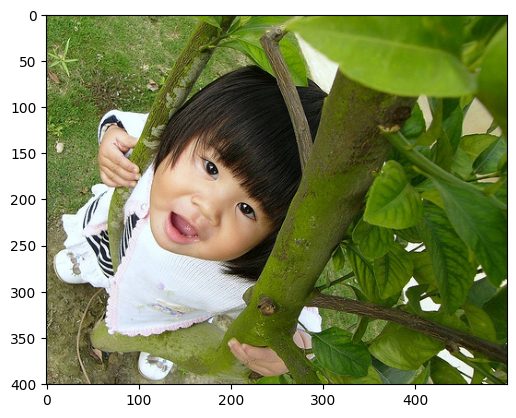

1/1 [==============================] - 0s 49ms/step



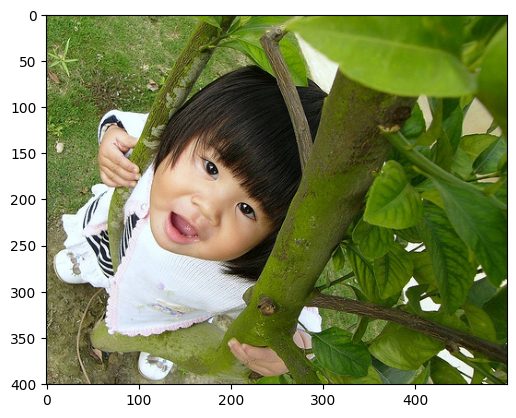

1/1 [==============================] - 0s 57ms/step



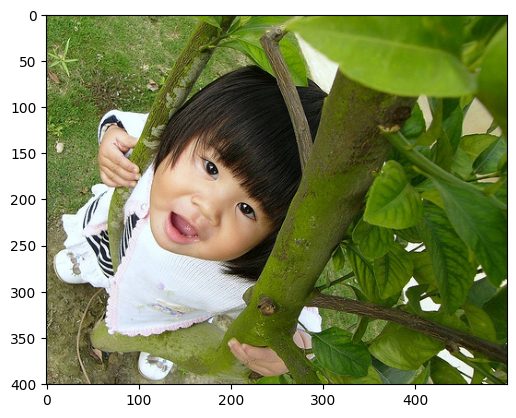

1/1 [==============================] - 0s 47ms/step



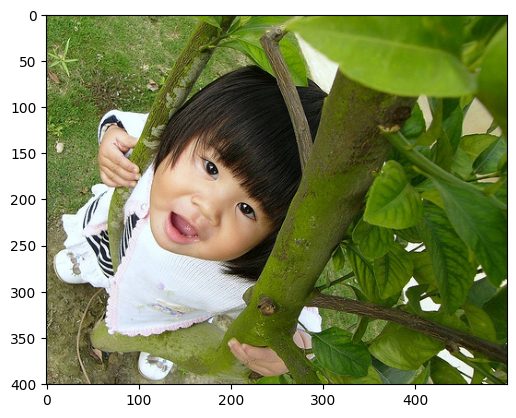

1/1 [==============================] - 0s 49ms/step



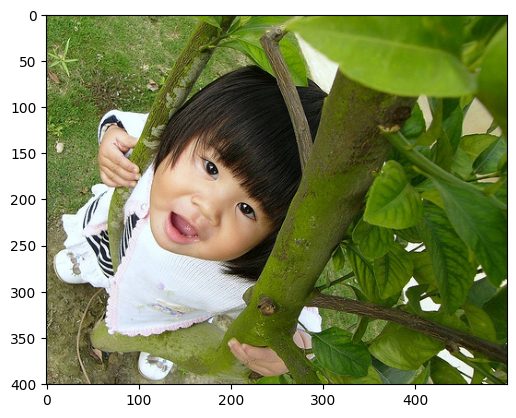

1/1 [==============================] - 0s 49ms/step



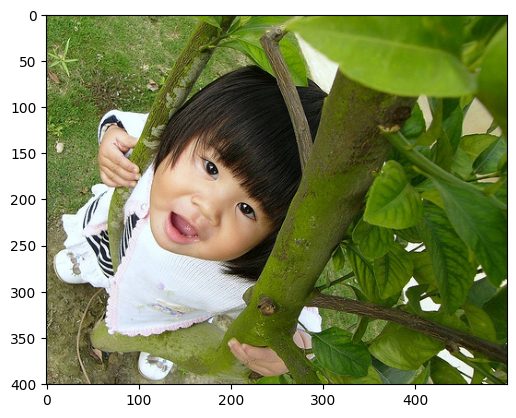

1/1 [==============================] - 0s 54ms/step



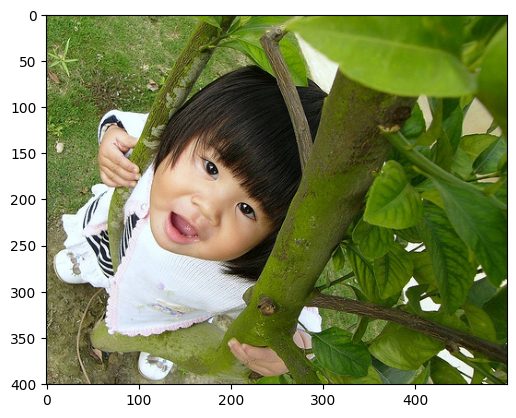

1/1 [==============================] - 0s 47ms/step



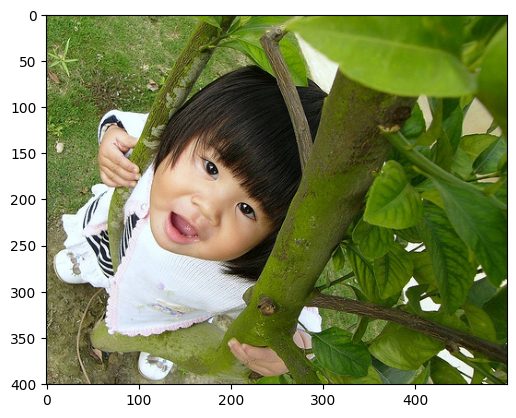

In [156]:
for i in range(15):
    idx=np.random.randint(0,1)
    all_img_names=list(encoding_test.keys())
    img_name=all_img_names[idx]
    photo_2048=encoding_test[img_name].reshape((1,2048))
    
    i=plt.imread(img_name+".jpg")
    caption=predict_captions(photo_2048)
    print(caption)
    plt.imshow(i)
    plt.show()